In [1]:
import numpy as np 
from scipy.special import gammaincinv

from astropy.modeling import models 
from astropy.modeling import models, fitting
from astropy.table import Table

from petrofit.models import sersic_enclosed, sersic_enclosed_inv, petrosian_profile, sersic_enclosed, make_grid, PSFModel
from petrofit.petrosian import Petrosian, PetrosianCorrection, calculate_petrosian
from petrofit.fitting import model_to_image, fit_model
from petrofit.photometry import calculate_photometic_density 
from petrofit.segmentation import make_catalog, plot_segments
from petrofit.photometry import make_radius_list
from petrofit.photometry import source_photometry
from petrofit.petrosian import Petrosian

%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

# Fake Sersic Profile Test

0.5


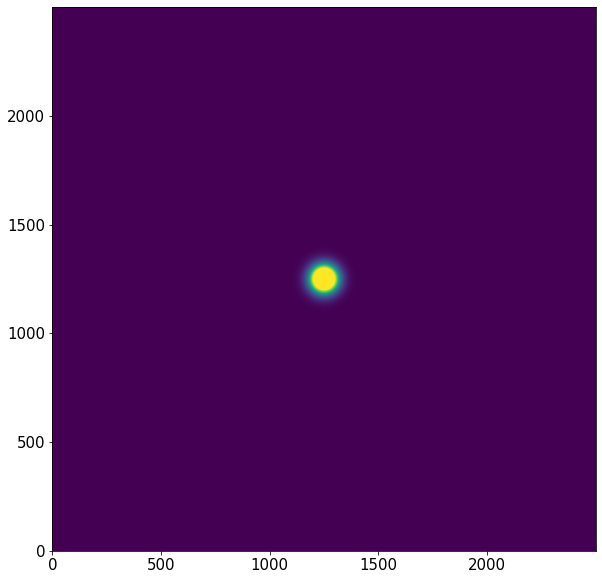

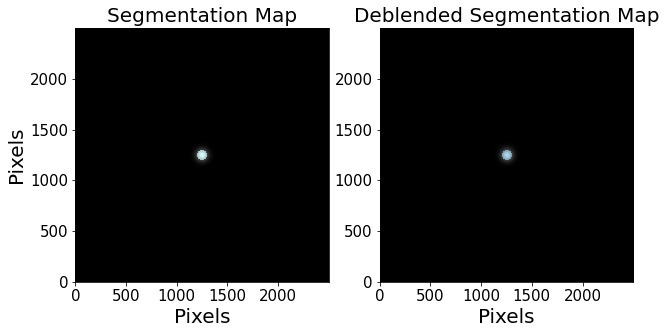

1


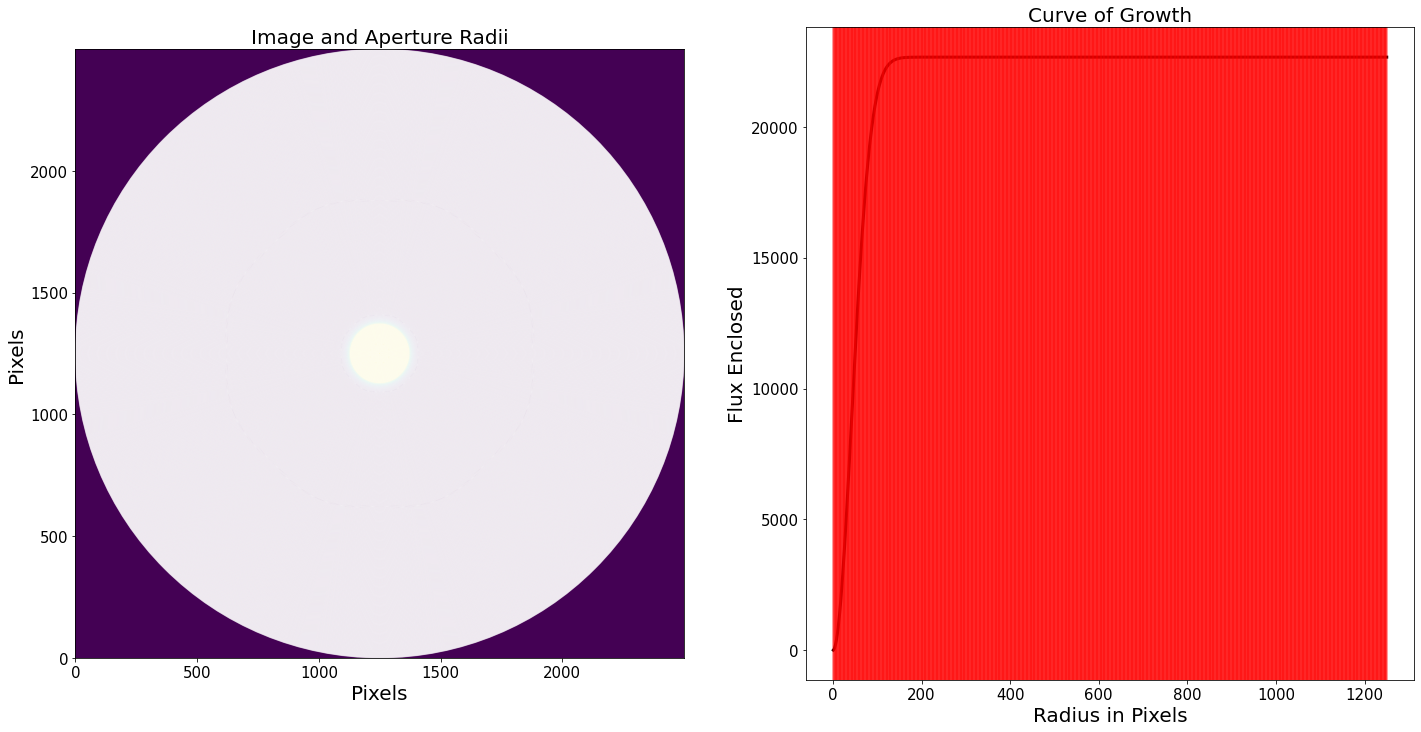

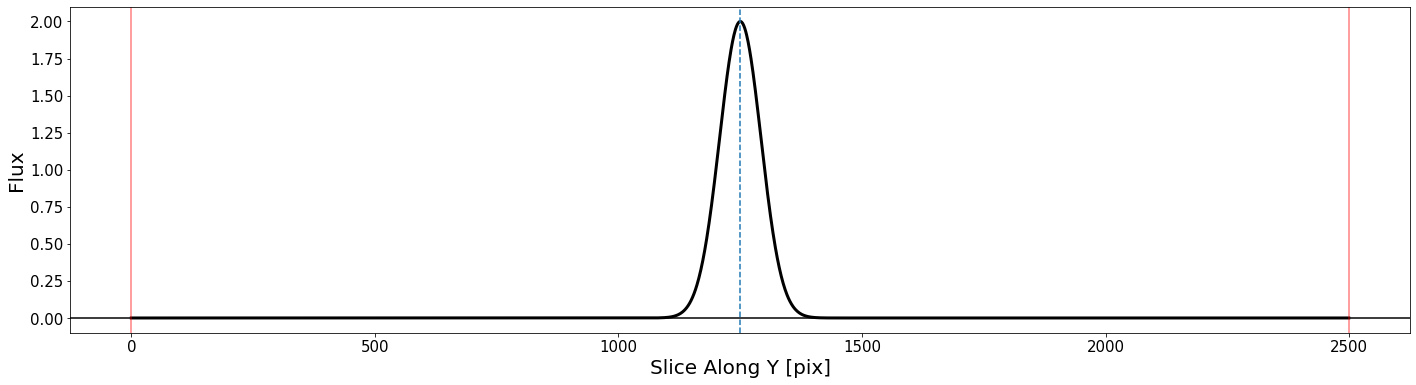

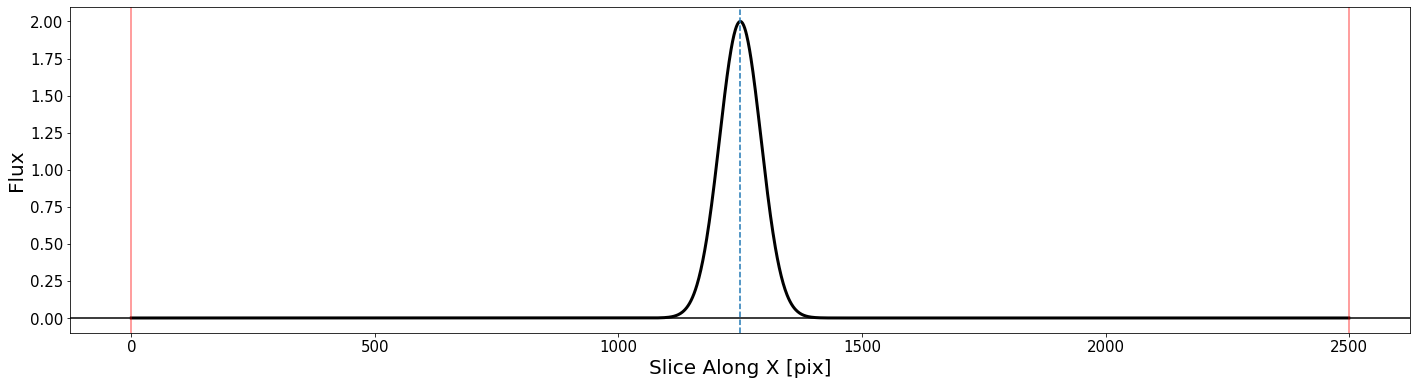

1.305894879504082
1.305894879504082


1


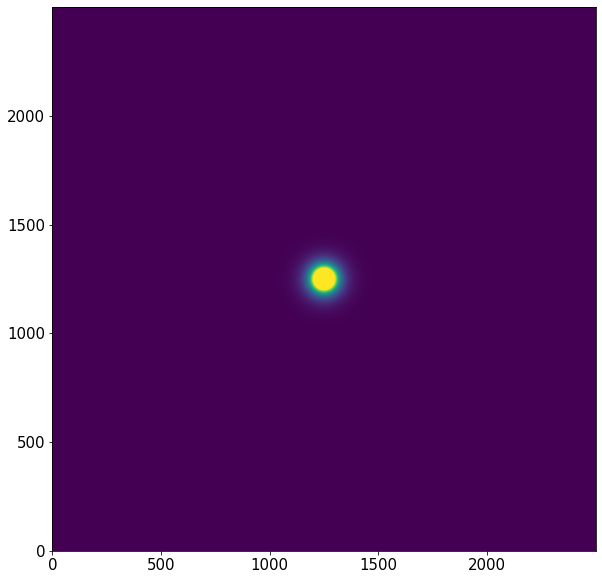

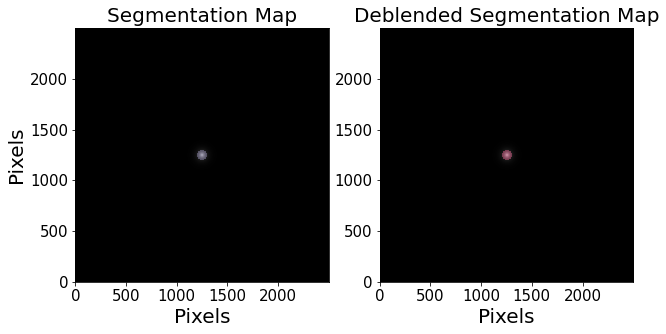

1


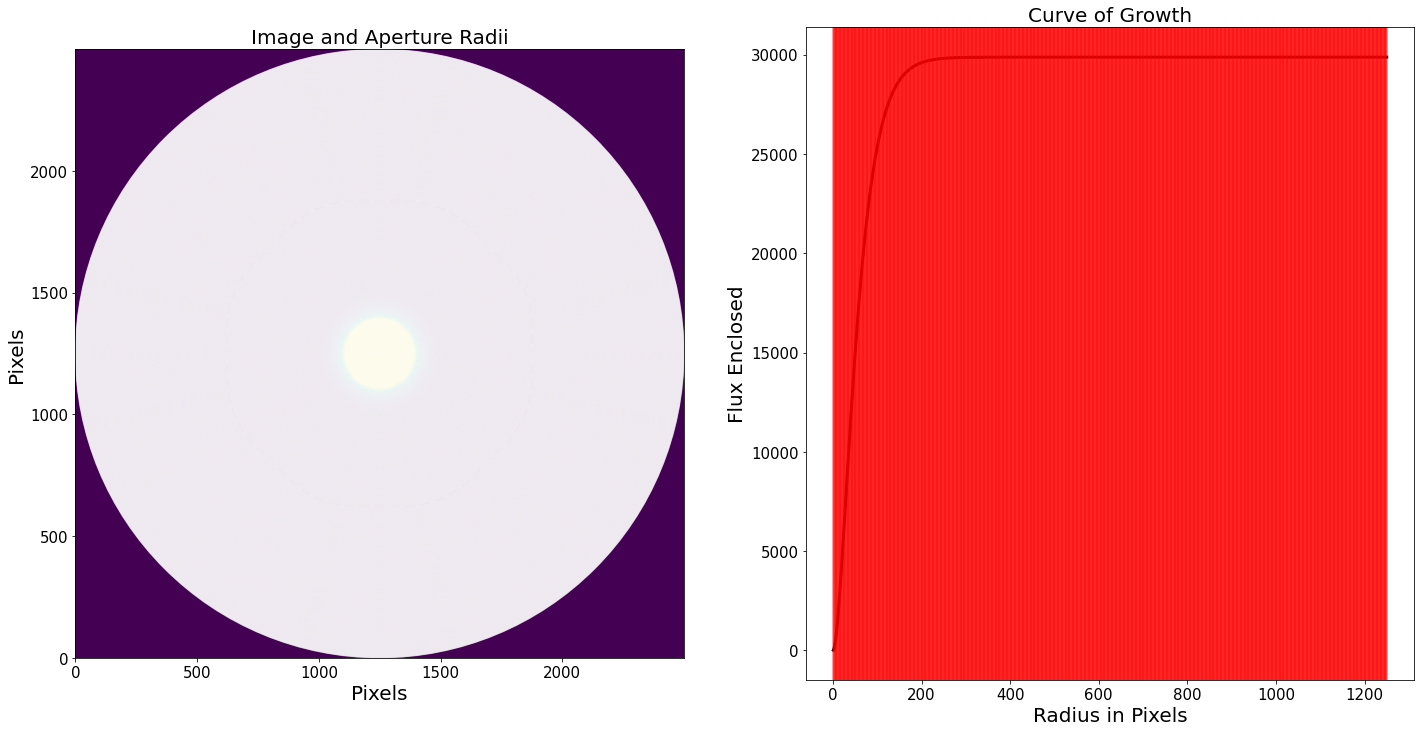

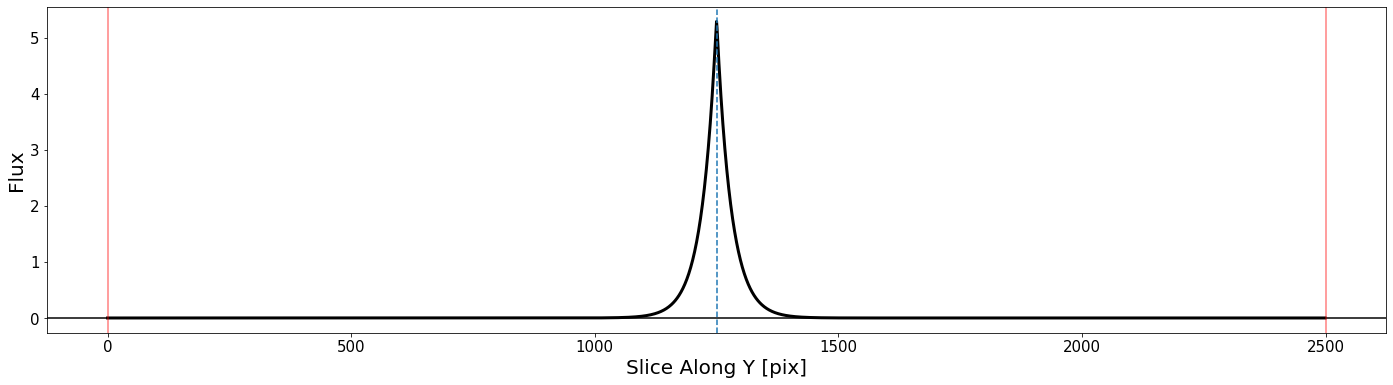

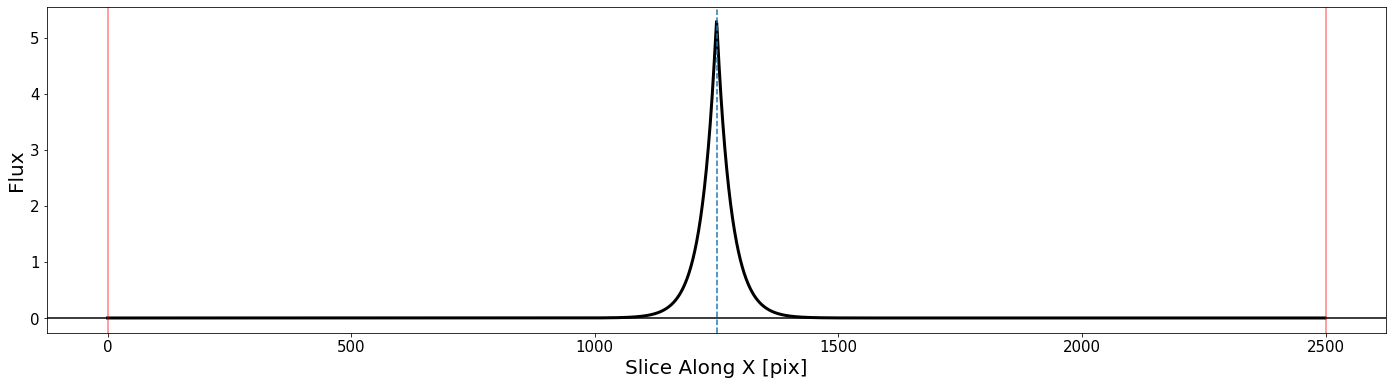

1.7988142587501468
1.7988142587501468


4


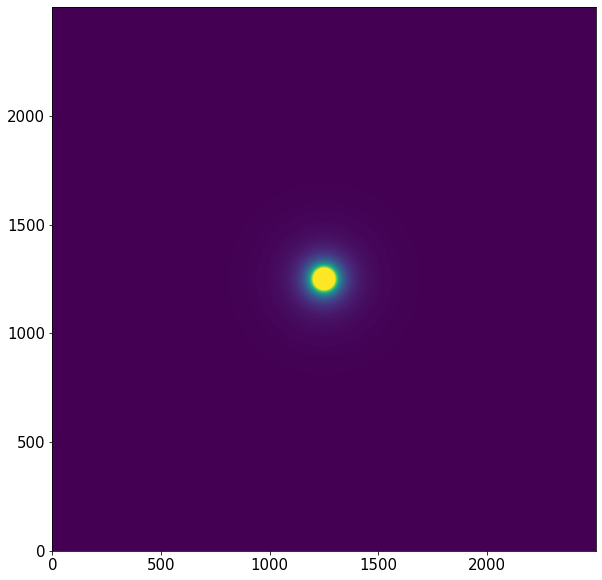

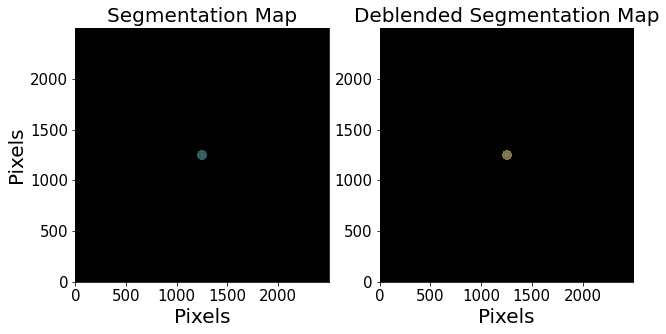

1


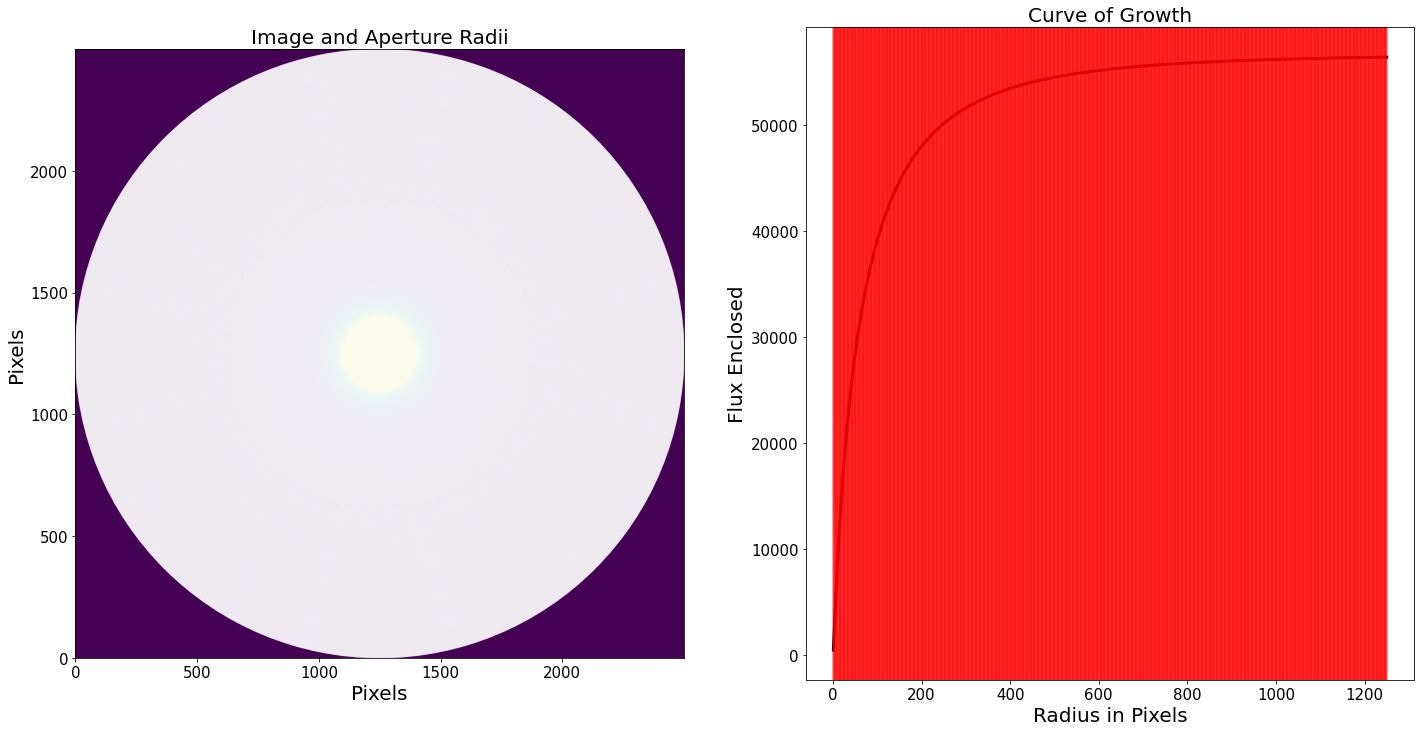

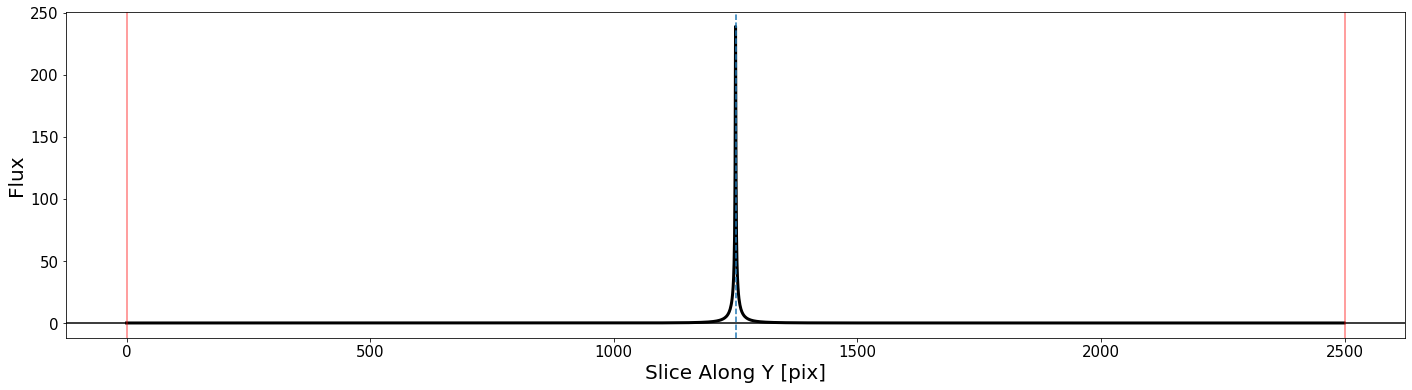

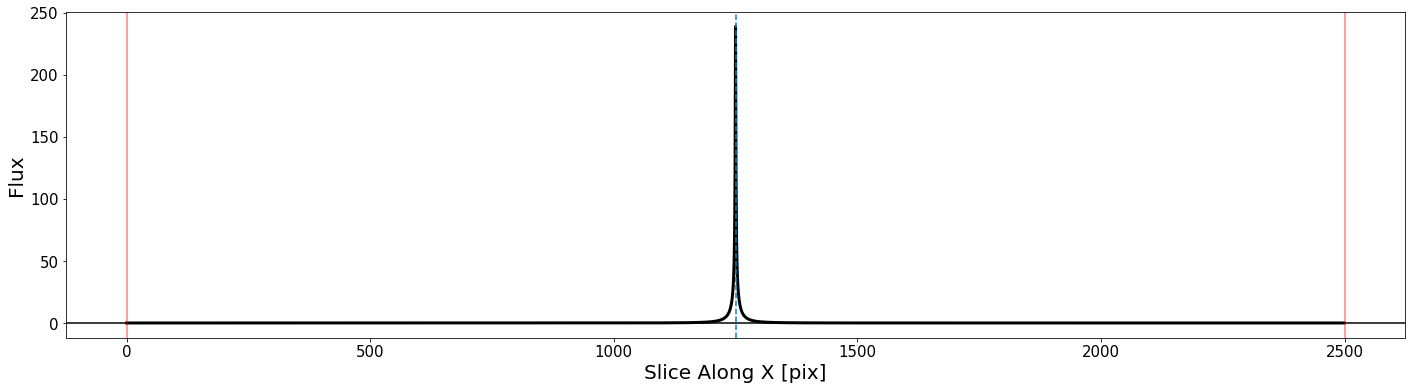

9.366887465893416
9.366887465893416




In [36]:

rows = []
for n in [0.5, 1, 4]:
    print(n)
    imsize = 2500
    amplitude=1
    r_eff=50
    x_0=imsize//2
    y_0=imsize//2
    ellip=0
    theta=0

    sersic_model = models.Sersic2D(
        amplitude=amplitude,
        r_eff=r_eff,
        n=n,
        x_0=x_0,
        y_0=y_0,
        ellip=ellip,
        theta=theta,
    )
    
    oversample_factor = 10 
    sersic_model = PSFModel.wrap(sersic_model, oversample=('x_0', 'y_0', 100, oversample_factor))
    model_image = model_to_image(imsize//2,imsize//2, imsize, sersic_model)

    plt.imshow(model_image, vmin=0, vmax=1)



    # Define smoothing kernel
    kernel_size = None 
    fwhm = 3
    npixels = 9

    cat, segm, segm_deblend = make_catalog(
        model_image,
        amplitude,
        deblend=True,
        kernel_size=kernel_size,
        fwhm=fwhm,
        npixels=npixels,
        plot=True
    )
    plt.show()


    max_pix=imsize//2
    r_list = make_radius_list(
        max_pix=max_pix, # Max pixel to go up to
        n=max_pix,# the number of radii to produce
    )

    # Photomerty
    flux_arr, area_arr, error_arr = source_photometry(

        # Inputs
        cat[0], # Source (`photutils.segmentation.catalog.SourceCatalog`)
        model_image, # Image as 2D array
        segm_deblend, # Deblended segmentation map of image
        r_list, # list of aperture radii

        # Options
        cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius
        bkg_sub=False, # Subtract background
        sigma=1, sigma_type='clip', # Fit a 2D plane to pixels within 1 sigma of the mean
        plot=True, # Show plot with max and min defined above
    )
    plt.show()


    p = Petrosian(r_list, area_arr, flux_arr)

    pc = PetrosianCorrection("example_correction_gid_no_psf.yaml")

    #n_est, epsilon = pc.estimate_regressor(p.r_half_light, p.c2080)

    n_est = pc.estimate_n(p.r_half_light, p.c2080)
    epsilon = pc.estimate_epsilon(p.r_half_light, p.c2080)
    print(epsilon)

    #𝐶2080 =  p_raw.c2080
    #epsilon = 10#2.32*(𝐶2080**4) - 31.47*(𝐶2080**3) + 160.73*(𝐶2080**2) - 363.67*𝐶2080 + 308.22
    print(epsilon)

    p_corr = Petrosian(r_list, area_arr, flux_arr, epsilon=epsilon)

    plt.show()

    total_flux = sersic_enclosed(np.inf, amplitude, r_eff, n)
    enclosed_99 = total_flux*.99

    r_99 = sersic_enclosed_inv(enclosed_99, amplitude, r_eff, n)
    r_20 = sersic_enclosed_inv(enclosed_99*0.2, amplitude, r_eff, n)
    r_80 = sersic_enclosed_inv(enclosed_99*0.8, amplitude, r_eff, n)

    rows.append([
        n, r_eff, amplitude, total_flux, r_99, r_20, r_80, 5 *np.log10(r_80 / r_20),
        p_corr.eta, p_corr.epsilon, p_corr.r_petrosian, p_corr.r_half_light, p_corr.r_total_flux, p_corr.total_flux, *p_corr.concentration_index(),
        p.eta, p.epsilon, p.r_petrosian, p.r_half_light, p.r_total_flux, p.total_flux, *p.concentration_index()
    ])
    print('\n')

names = [
        "sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_c2080",
        "corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_c2080",
        'uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80', 'uncorr_c2080'
    ]

t = Table(rows=rows, names=names)

In [38]:
#t.write('simulated_2d_sersic_params.csv', overwrite=True)
# t = Table.read('simulated_2d_sersic_params.csv')

In [4]:
sersic_names = ["sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_c2080"]
corr_names =   ["corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_c2080"]
uncorr_names = ['uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80', 'uncorr_c2080']


In [5]:
sersic_names = ["corr_eta", "sersic_r_eff",]
corr_names =   ["corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_c2080"]
uncorr_names = [i.replace('corr_', 'uncorr_') for i in corr_names]


In [6]:
from IPython.display import display

In [37]:
name_col = [
    'eta',
    'epsilon',
    'r_petrosian',
    'r_half_light',
    'r_total_flux',
    'total_flux',
    'r_20',
    'r_80',
    'c2080'
]

name_col = [i.replace('_', '\_') for i in name_col]
for i in range(len(t)):

    sersic_col = [
        t[i]['corr_eta'], 
        t[i]['sersic_r_99']/t[i]['corr_r_petrosian'],
        t[i]['corr_r_petrosian'],
        t[i]['sersic_r_eff'],
        t[i]['sersic_r_99'],
        t[i]['sersic_total_flux_99'],
        t[i]['sersic_r_20'],
        t[i]['sersic_r_80'],
        t[i]['sersic_c2080'],
    ]

    mt = Table(
        np.array(list(zip(
            name_col, 
            np.round(sersic_col, 2),
            np.round(list(t[i][uncorr_names]), 2),
            np.round(list(t[i][corr_names]), 2),
        ))),
        names=["Values", "Sersic", "Uncorrected", "Corrected"]
    )
    
    for row in mt:
        if not np.isnan(float(row[1])):
            formatter = "{} ({})"# if row[0] != "total\_flux" else "{:.2e} ({})"
            row[2] = formatter.format(float(row[2]), np.round((float(row[2])/float(row[1])), 2))
            row[3] = formatter.format(float(row[3]), np.round((float(row[3])/float(row[1])), 2))
        else:
            row[1] = 'N/A'
    
    n = t[i]['sersic_n']
    mt.write('simulated_2d_sersic_params_n{}.csv'.format(n), overwrite=True)
        
    display(mt)

Values,Sersic,Uncorrected,Corrected
str32,str32,str32,str32
eta,0.2,0.2 (1.0),0.2 (1.0)
epsilon,1.3,2.0 (1.54),1.31 (1.01)
r\_petrosian,98.77,98.77 (1.0),98.77 (1.0)
r\_half\_light,50.0,50.01 (1.0),49.76 (1.0)
r\_total\_flux,128.88,197.54 (1.53),128.98 (1.0)
total\_flux,22661.8,22660.98 (1.0),22436.45 (0.99)
r\_20,28.21,28.26 (1.0),28.26 (1.0)
r\_80,75.26,76.27 (1.01),75.27 (1.0)
c2080,2.13,2.16 (1.01),2.13 (1.0)


Values,Sersic,Uncorrected,Corrected
str32,str32,str32,str32
eta,0.2,0.2 (1.0),0.2 (1.0)
epsilon,1.82,2.0 (1.1),1.8 (0.99)
r\_petrosian,108.77,108.77 (1.0),108.77 (1.0)
r\_half\_light,50.0,49.76 (1.0),49.51 (0.99)
r\_total\_flux,197.76,217.54 (1.1),195.66 (0.99)
total\_flux,29871.24,29703.68 (0.99),29553.21 (0.99)
r\_20,24.39,24.5 (1.0),24.5 (1.0)
r\_80,87.64,88.27 (1.01),87.52 (1.0)
c2080,2.78,2.78 (1.0),2.76 (0.99)


Values,Sersic,Uncorrected,Corrected
str32,str32,str32,str32
eta,0.2,0.2 (1.0),0.2 (1.0)
epsilon,10.21,2.0 (0.2),9.37 (0.92)
r\_petrosian,92.77,92.77 (1.0),92.77 (1.0)
r\_half\_light,50.0,36.76 (0.74),49.01 (0.98)
r\_total\_flux,947.18,185.54 (0.2),868.95 (0.92)
total\_flux,56663.08,47160.67 (0.83),55967.71 (0.99)
r\_20,13.81,11.5 (0.83),13.75 (1.0)
r\_80,152.71,91.27 (0.6),151.53 (0.99)
c2080,5.22,4.5 (0.86),5.21 (1.0)
